# Visualizing Optimization Algorithms

## 1. Intro

The task in this lab session is to implement a subset of the known optimization algorithms used in neural network training. 

Specifically, you are given a function ([The Beale Function](https://www.sfu.ca/~ssurjano/beale.html)) simulating the _loss_ space in which gradient descent with respect to the parameters needs to be performed. To simplify visualization, the function that models the loss space is defined over two parameters: $(x, y)$.

Your task is to implement a method to compute the gradient of the loss function with respect to its two parameters and then use the gradient vector to implement and analyze the behavior of the following optimization methods:

- [x] **SGD** 
- [x] **Momentum**
- [ ] **Nesterov Gradient**
- [ ] **Adagrad**
- [ ] **Adadelta**
- [ ] **RMSProp** 
- [ ] **Adam**.

### Imports

In [62]:
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [63]:
import matplotlib.pyplot as plt
import numpy as np
#import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
#from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

**Define Beale function**

We have to compute the gradients for the following function:

$b(x, y) = (1.5 - x + x*y)^2 + (2.25 - x + x*y^2)^2 + (2.625 - x + x*y^3)^2$

In [64]:
def beale(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

**Define plot limits**

In [65]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

In [66]:
mesh_x, mesh_y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [67]:
mesh_z = beale(mesh_x, mesh_y)

The **global  minimum** of the Beale function is at $(3, 0.5)$. Let us check that it is indeed so:

In [68]:
minimum = np.array([3, 0.5])
beale(*minimum)

0.0

Transpose minimum to be used for plotting:

In [69]:
minimum_t = minimum.reshape(-1, 1)
print(minimum_t.shape)

beale(*minimum_t)

(2, 1)


array([0.])

### 1.1 Visualization of the 3D Surface Plot of the Beale Function

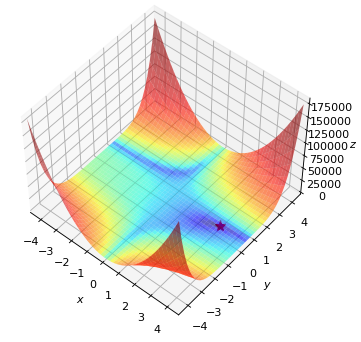

In [70]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(mesh_x, mesh_y, mesh_z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.6, cmap=plt.cm.jet)
ax.plot(*minimum_t, beale(*minimum_t), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

Let us plot the Gradient Vector Field. We use `autograd` to compute it and the Matplotlib `quiver` method to plot it.

In [71]:
dbeale_dx = elementwise_grad(beale, argnum=0)(mesh_x, mesh_y)
dbeale_dy = elementwise_grad(beale, argnum=1)(mesh_x, mesh_y)

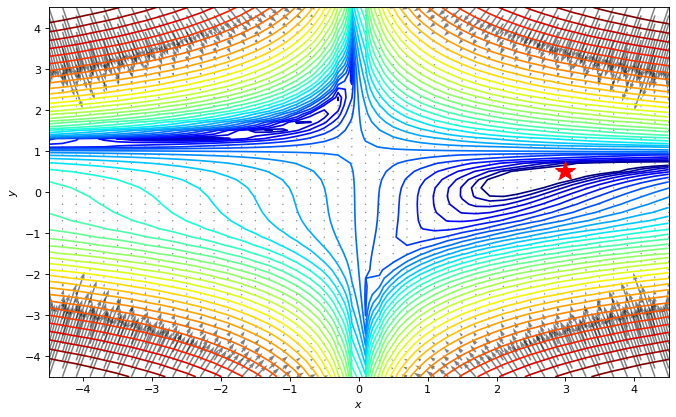

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(mesh_x, mesh_y, mesh_z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(mesh_x, mesh_y, mesh_x - dbeale_dx, mesh_y - dbeale_dy, alpha=.5)
ax.plot(*minimum_t, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

### 1.2 Helper functions

`trace_path` allows you to visualize the trace of parameter values given by each optimization method. `optimization_sol` contains a list of numpy arrays, each with 2 elements: (x, y) values for the two parameters defining the loss function.

In [73]:
def trace_path(optimization_sol):
    path = np.array(optimization_sol).T

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(mesh_x, mesh_y, mesh_z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
    ax.plot(*minimum_t, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    plt.show()

`view_update_history` allows you to visualize the history of _parameter updates_ (i.e. $\Delta \theta$ values) produced by each optimization method. `updates` is a list of numpy arrays , each with two elements: the update values for the (x, y) parameters at a given time step.

In [74]:
def view_update_history(updates):
    deltas = np.array(updates).T
    
    delta_x = deltas[0, :]
    delta_y = deltas[1, :]
    
    xx = np.arange(0, delta_x.shape[0])
    
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(xx, delta_x, 'o-')
    plt.title('Parameter update history')
    plt.ylabel('Updates to x direction')

    plt.subplot(2, 1, 2)
    plt.plot(xx, delta_y, 'o-')
    plt.xlabel('Update step')
    plt.ylabel('Updates to y direction')

    plt.show()

## 2. Optimization algorithms

We set the starting point as  $(1,1.75)$ , since it will allow us to exemplify overshoot behavior in momentum based gradient descent update rules. 

After you complete all tasks, you can rerun your optimizers with the other starting points, to analyze cases where the update rules lead to overshooting and ending up in some local minima.

In [75]:
start_tall = np.array([3., 4.])
start_med = np.array([1., 1.75])
start_low = np.array([1., 1.])

EPOCHS = 1000

### TODO 2.1: compute the gradient of the beale function. 
The function has to return a tuple `(df_dx, df_dy)` representing the gradient vector of the Beale function in point `(x, y)`

In [76]:
def grad_beale(x, y):
    # TODO 1
    df_dx = 2*((1.5 - x + x*y)*(y - 1) + (2.25 - x + x*y**2)*(y**2 - 1) + (2.625 - x + x*y**3)*(y**3 - 1))
    df_dy = 2*((1.5 - x + x*y)*x + (2.25 - x + x*y**2)*(2*x*y) + (2.625 - x + x*y**3)*(3*x*y**2))
    
    return df_dx, df_dy

Let's verify if we have computed the gradient correctly by comparing the result with the output of the `elementwise_grad` function from `autograd`:

In [77]:
ref_dx = elementwise_grad(beale, argnum=0)(mesh_x, mesh_y)
ref_dy = elementwise_grad(beale, argnum=1)(mesh_x, mesh_y)

df_dx, df_dy = grad_beale(mesh_x, mesh_y)

df_dx = np.array(df_dx)
df_dy = np.array(df_dy)

np.testing.assert_array_almost_equal(ref_dx, df_dx, decimal = 6, verbose=True)
np.testing.assert_array_almost_equal(ref_dy, df_dy, decimal = 6, verbose=True)


### TODO 2.2 Implement the SGD optimizer
$ \theta^{(k+1)} = \theta^{(k)} + \lambda \nabla_{\theta} J(x^{(k)}, \theta^{(k)}) $

In [78]:
def SGD_beale(start=start_med, target=minimum, lr=1e-3, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    while idx < epochs:
        dx, dy = grad_beale(*params)
        dx = np.array(dx)
        dy = np.array(dy)
        
        delta_params = lr * np.array([dx, dy]) 
        
        params = params - delta_params
        
        # we are saving the parameter values and the update deltas to plot them
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

In [79]:
np.random.seed(42)

In [80]:
def SGD_beale_noisy(start=start_med, target=minimum, lr=1e-3, epochs=EPOCHS, noise_strength=0.5):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    while idx < epochs:
        noise = noise_strength * np.random.randn(params.size)
        
        dx, dy = grad_beale(*params)
        dx = np.array(dx)
        dy = np.array(dy)
        
        delta_params = lr * np.array([dx, dy] + noise) 
        
        params = params - delta_params
        
        # we are saving the parameter values and the update deltas to plot them
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

Save the parameter trace, the update vectors and the final distance from the global minimum

In [81]:
sgd_sol, sgd_updates, sgd_diff = SGD_beale_noisy(start=start_med)

Visualize SGD parameter trace and update vector history.

The expected distance from the true minimum, when running SGD with default parameters: `1.017168167327364`

![SGD Parameter Path](img/sgd_parameter_path.png)

0.5849164244107784


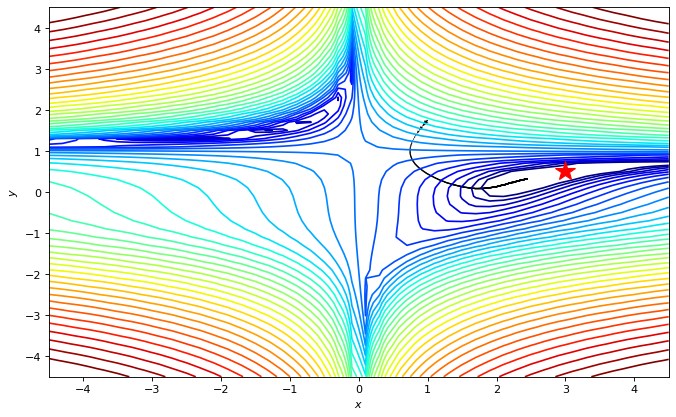

In [82]:
print(sgd_diff)
trace_path(sgd_sol)

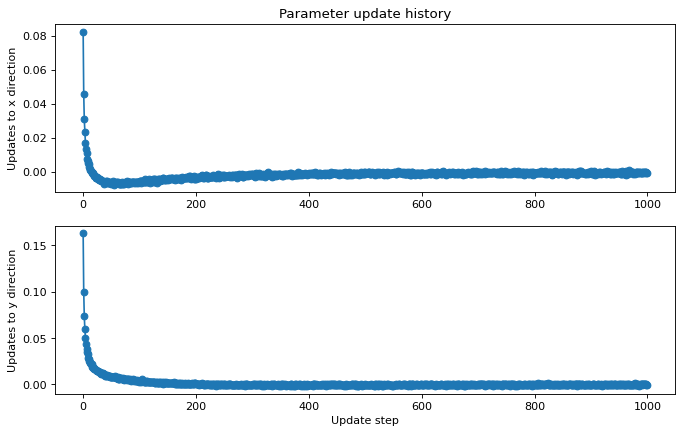

In [83]:
view_update_history(sgd_updates)

### Task 2.3 Implement the SGD with Momentum optimizer
\begin{align*}
        \Delta\theta_t = \gamma \Delta\theta_{t-1} + \lambda \nabla_{\theta} J(\theta)
\end{align*}


\begin{align*}
        \theta^{(t + 1)} = \theta^{(t)} - \Delta\theta_t
\end{align*}

In [84]:
def momentum_beale(start=start_med, target=minimum, lr=1e-3, gamma=0.9, epochs=EPOCHS):
    delta_params = np.zeros(2)
    
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    while idx < epochs:
        dx, dy = grad_beale(*params)
        
        ## TODO 
        ## We keep track of the direction; this comes from the Heavy Ball problem
        delta_params = gamma * delta_params + lr * np.array([dx, dy])
        
        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)
    

In [85]:
EPOCHS=400

momentum_sol, momentum_updates, momentum_diff = momentum_beale(start=start_med)

The expected distance from the true minimum, when running Momentum with default parameters: `0.13853887236394447`

![Momentum Parameter Path](img/momentum_parameter_path.png)

0.017785123116359935


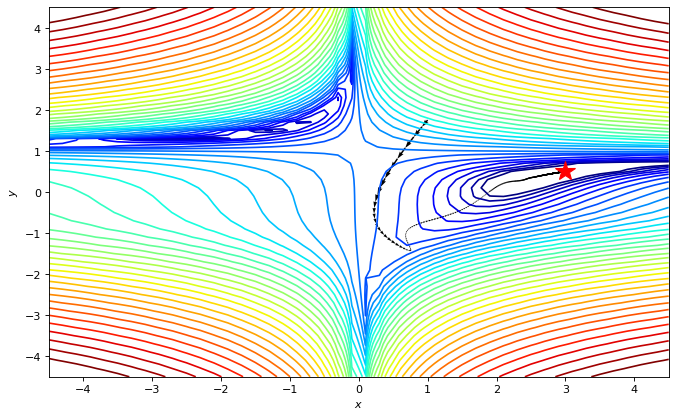

In [86]:
print(momentum_diff)
trace_path(momentum_sol)

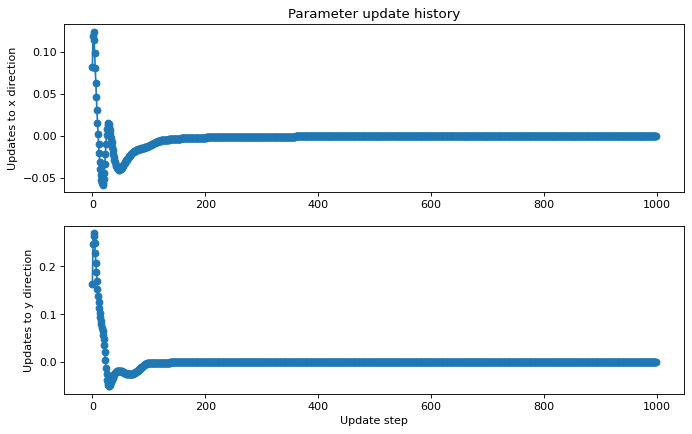

In [87]:
view_update_history(momentum_updates)

### TODO 2.4 Implement Nesterov Accelerated Gradient optimizer
NAG performs a "look-ahead" strategy by computing the gradient of the loss function in a point given by future estimated parameter values $\theta - \gamma \Delta\theta_{t-1}$, instead of the current $\theta$. Since we do not have the _new_ $\Delta \theta_t$, we approximate the future parameter values with the previous update $\Delta \theta_{t-1}$
    
  \begin{align*} 
        \Delta\theta_t = \gamma \Delta\theta_{t-1} + \lambda \nabla_{\theta} J(\theta - \gamma \Delta\theta_{t-1})
  \end{align*}
   
  \begin{align*}
        \theta^{(t + 1)} = \theta^{(t)} - \Delta\theta_{t}
  \end{align*}

In [88]:
def nesterov_beale(start=start_med, target=minimum, lr=1e-3, gamma=0.9, epochs=EPOCHS):
    delta_params = np.zeros(2)
    
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    while idx < epochs:
        ## TODO
        look_ahead = params - gamma * delta_params
        dx, dy = grad_beale(*look_ahead)
        delta_params = gamma * delta_params + lr * np.array([dx, dy])  
        
        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)
    

In [89]:
nesterov_sol, nesterov_updates, nesterov_diff = nesterov_beale(start=start_med)

The expected distance from the true minimum, when running Nesterov Accelerated Gradient with default parameters: `0.13359752885046636`

![Nesterov Parameter Path](img/nesterov_parameter_path.png)

0.13359752885046636


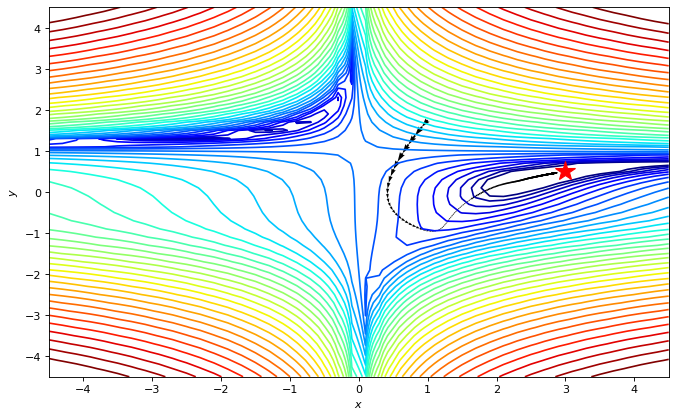

In [90]:
print(nesterov_diff)
trace_path(nesterov_sol)

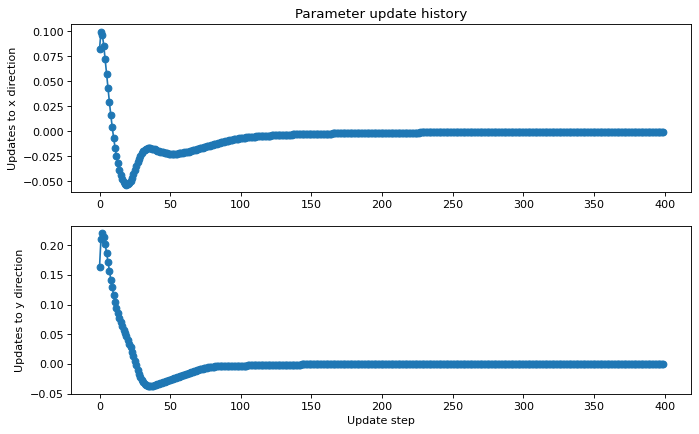

In [91]:
view_update_history(nesterov_updates)

### Task 2.5 Implement Adagrad optimizer
Adagrad tries to adjust the learning rate for each parameter by decaying it using the history of past gradient updates.

The gradient with respect to parameter $\theta_i$ at step $t$ is written as: $g_{t,i} = \nabla J_{\theta}(\theta^{(t)}_i)$.


The Adagrad update rule is the following:
$\theta^{(t+1)}_i = \theta^{(t)}_i - \frac{\lambda}{\sqrt{G_{t,ii} + \epsilon}} g_{t,i}$, 

where $G_t \in \mathbb{R}^{d \times d}$ - diagonal matrix. Element $i,i$ on the diagonal = sum of squares of past gradients (up to step $t$) for parameter $\theta_i$.

In [31]:
def adagrad_beale(start=start_med, target=minimum, lr=1e-2, eps=1e-5, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    G = np.zeros((start.shape[0], start.shape[0]))
    
    while idx < epochs:
        dx, dy = grad_beale(*params)
        
        ## TODO
        ## delta_params = ....
        
        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)
    

In [32]:
adagrad_sol, adagrad_updates, adagrad_diff = adagrad_beale(start=start_med, lr=1e-1)

NameError: name 'delta_params' is not defined

The expected distance from the true minimum, when running Adagrad with default parameters: `1.580078329786008`

![Adagrad Parameter Path](img/adagrad_parameter_path.png)

In [ ]:
print(adagrad_diff)
trace_path(adagrad_sol)

In [ ]:
view_update_history(adagrad_updates)

### TODO 2.6 Implement the Adadelta optimizer
In Adadelta we simulate a _window_ of past gradient updates by computing a decaying running average of past squared gradients.

$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) g^2_t, \text{where } E[g^2]_t \text{ is the running average at step t.}$
<br/><br/>

Adadelta also defines an exponential decay of squared parameter updates ($\Delta \theta$).

$E[\Delta\theta^2]_t = \gamma E[\Delta\theta^2]_{t-1} + (1 - \gamma) \Delta\theta^2_t$
<br/><br/>

The Adadelta update rule is thus:

\begin{align*}
        RMS[\Delta\theta]_t &= \sqrt{E[\Delta\theta^2]_t + \epsilon} \\
        %
        \Delta\theta_t &= \frac{RMS[\Delta \theta]_{t-1}}{RMS[g]_t} g_t, \text{where } RMS[\Delta \theta]_{t-1} \text{ replaces } \lambda \\
        %
        \theta^{(t+1)} &= \theta^{(t)} - \Delta \theta_t
\end{align*}

In [ ]:
def adadelta_beale(start=start_med, target=minimum, gamma=0.9, eps=1e-5, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    Etheta = np.zeros(start.shape[0])
    Eg = np.zeros(start.shape[0])
    
    while idx < epochs:
        dx, dy = grad_beale(*params)
        grad = np.array([dx, dy])
        
        ## Update the parameter holding the decayed average of previous gradient-square values
        ## Eg = ...
        ## Compute RMS[g] = ....
        
        ## Compute RMS[theta]
        ## RMStheta = .... 
        
        ## Compute delta_params
        ## delta_params = ....

        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        ## Compute Etheta 
        ## Etheta = ....
 
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

In [ ]:
adadelta_sol, adadelta_updates, adadelta_diff = adadelta_beale(start=start_med)

The expected distance from the true minimum, when running Adadelta with default parameters: `0.3303773602709788`

![Adadelta Parameter Path](img/adadelta_parameter_path.png)

In [ ]:
print(adadelta_diff)
trace_path(adadelta_sol)

In [ ]:
view_update_history(adadelta_updates)

### TODO 2.7 Implement RMSProp optimizer
RMSProp works almost the same as Adadelta, but it reintroduces a global learning rate $\lambda$, instead of the $RMS[\Delta \theta]$ term.

The RMSProp update rule is:
\begin{align*}
        E[g^2]_t &= 0.9 E[g^2]_{t-1} + 0.1 g^2_t\\
        \theta^{(t+1)} &= \theta^{(t)} - \frac{\lambda}{\sqrt{E[g^2]_t + \epsilon}} g_t
\end{align*}

In [ ]:
def rmsprop_beale(start=start_med, target=minimum, lr=1e-3, gamma=0.9, eps=1e-5, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    
    params = start
    Eg = np.zeros(start.shape[0])
    
    while idx < epochs:
        dx, dy = grad_beale(*params)
        grad = np.array([dx, dy])
        
        ## TODO
        ## Ef = ....
        
        ## TODO
        ## RMSg = ...
        
        ## TODO
        ## delta_params = ....

        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

In [ ]:
rmsprop_sol, rmsprop_updates, rmsprop_diff = rmsprop_beale(start=start_med, lr=1e-2)

The expected distance from the true minimum, when running RMSPropwith default parameters: `0.09687844841688657`

![RMSProp Parameter Path](img/rmsprop_parameter_path.png)

In [ ]:
print(rmsprop_diff)
trace_path(rmsprop_sol)

In [ ]:
view_update_history(rmsprop_updates)

### TODO 2.8 Implement Adam optimizer


For Adam we store two averages:
    - store exponentially decaying average of _squared gradients_ $v_t$ (second moment - variance)
    - store exponentially decaying average of _past gradients_ $m_t$ (first moment - mean), similar to momentum
    
\begin{align*}
        m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
        %
        v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g^2_t
\end{align*}

Perform bias correction to avoid having $m_t$ and $v_t$ too close to 0.

\begin{align*}
        \hat{m}_t &= \frac{m_t}{1-\beta_1^t}\\
        \hat{v}_t &= \frac{v_t}{1-\beta_2^t}
\end{align*}

The Adam update rule is then:
\begin{align*}
    \theta^{(t+1)} = \theta^{(t)} - \frac{\lambda}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
\end{align*}

In [ ]:
def adam_beale(start=start_med, target=minimum, lr=1e-3, beta1=0.9, beta2=0.9, eps=1e-5, epochs=EPOCHS):
    idx = 0
    solutions = [start]
    updates = []
    params = start
    
    m = np.zeros(start.shape[0])
    v = np.zeros(start.shape[0])
    
    beta1_norm = 1.0
    beta2_norm = 1.0
    
    while idx < epochs:
        dx, dy = grad_beale(*params)
        grad = np.array([dx, dy])
        
        ## TODO:
        ## delta_params = ...
        
        params = params - delta_params
        solutions.append(params)
        updates.append(delta_params)
        
        idx += 1
        
    return solutions, updates, np.linalg.norm(params - target)

In [ ]:
adam_sol, adam_updates, adam_diff = adam_beale(start=start_med, lr = 1e-2)

The expected distance from the true minimum, when running Adam with default parameters: `0.03735099816997893`

![Adam Parameter Path](img/adam_parameter_path.png)

In [ ]:
print(adam_diff)
trace_path(adam_sol)

In [ ]:
view_update_history(adam_updates)

## 3. Comparative visualization

We can compare the behavior of the implemented optimizers by animating the traces of parameter values.

In [ ]:
METHODS = [
    'sgd', 
    'momentum', 
    'nesterov', 
    'adagrad', 
    'adadelta', 
    'rmsprop', 
    'adam'
]

class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, paths_dict, fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):
        
        self.paths_dict = paths_dict
        
        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.__set_paths_and_labels()

        if frames is None:
            frames = max(path.shape[1] for path in self.paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(self.paths, self.labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def __set_paths_and_labels(self):
        self.paths = []
        self.labels = []
        
        for m in METHODS:
            if m in self.paths_dict:
                self.labels.append(m)
                self.paths.append( np.array(self.paths_dict[m]).T )
        
    
    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points


def animate_paths(paths_dict):
    # define figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.contour(mesh_x, mesh_y, mesh_z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    ax.plot(*minimum_t, 'r*', markersize=18)
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    
    anim = TrajectoryAnimation(paths_dict, ax = ax)
    
    ax.legend(loc='upper left')

    return anim

In [ ]:
# define paths_dict
paths_dict = {
    'sgd': sgd_sol[::2],
    'momentum': momentum_sol[::5],
    'nesterov': nesterov_sol[::5],
    'adagrad': adagrad_sol[::5],
    'adadelta': adadelta_sol[::5],
    'rmsprop': rmsprop_sol[::5],
    'adam': adam_sol[::5]
}

anim = animate_paths(paths_dict)

HTML(anim.to_html5_video())